In [69]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **Data Importing**

In [70]:
trainData = pd.read_csv('/kaggle/input/titanic/train.csv')
testData = pd.read_csv('/kaggle/input/titanic/test.csv')
genderSubmission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# **Basis Statistical Info**

In [71]:
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [72]:
trainData.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


# **Data Cleaning and Transforming**

In [73]:
# Dropping Irrelevant Columns
X = trainData.drop(labels=['Cabin', 'PassengerId', 'Name', 'Ticket', 'Survived'], axis=1)
y = trainData['Survived']

In [74]:
display(X)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,S
887,1,female,19.0,0,0,30.0000,S
888,3,female,NaN,1,2,23.4500,S
889,1,male,26.0,0,0,30.0000,C


In [75]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Column Type Selection for Preprocessing
numCols = X.select_dtypes(include=['number']).columns
catCols = X.select_dtypes(include=['object']).columns

# Define preprocessing pipelines
numTransformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

catTransformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())
])

preprocessor = ColumnTransformer([
    ("num", numTransformer, numCols),
    ("cat", catTransformer, catCols)
])

In [76]:
prep = Pipeline([
        ("preprocess", preprocessor)
    ])

X = prep.fit_transform(X)

In [77]:
X

array([[ 0.82737724, -0.56573646,  0.43279337, ..., -0.50244517,
         1.        ,  2.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  0.78684529,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ..., -0.48885426,
         0.        ,  2.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ..., -0.17626324,
         0.        ,  2.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ..., -0.04438104,
         1.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ..., -0.49237783,
         1.        ,  1.        ]])

[2025-10-26 22:22:35.072] [CUML] [info] Building knn graph using brute force


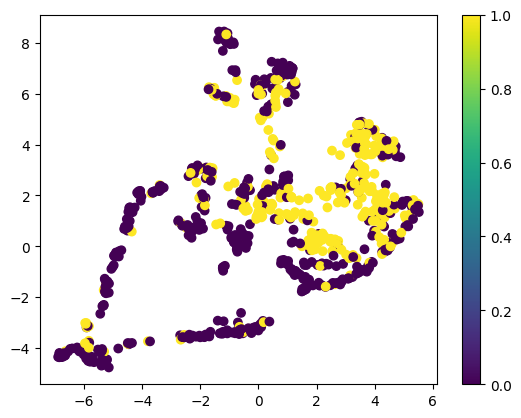

In [134]:
from cuml.manifold import UMAP
import matplotlib.pyplot as plt

umap = UMAP(n_components=2, n_neighbors=100, min_dist=0.25)
Z = umap.fit_transform(X)

plt.scatter(Z[:,0], Z[:,1], c=y)
plt.colorbar()
plt.show()

# **Models Selection and Hyperparams Optimization**

In [79]:
# Models Import
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from skopt import BayesSearchCV   # Hyperparams Optimization
from skopt.space import Real, Categorical, Integer

# Models Definition
models = {
    "GaussianNB": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "SVC": SVC()
}

# Search Spaces for Bayesian Hyperparams Optimization
searchSpaces = {
    "QDA": {
        "model__reg_param": Real(0, 1)
        },
    "KNN": {
        "model__n_neighbors": Integer(3, 15)
        },
    "DecisionTree": {
        'model__max_depth': Integer(3, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__max_features': Real(0.3, 0.8)
        },
    "RandomForest": {
        'model__n_estimators': Integer(50, 400),
        'model__max_depth': Integer(3, 20),
        'model__min_samples_leaf': Integer(1, 10),
        'model__max_features': Real(0.3, 0.8)
    },
    "SVC": {
        'model__C': Real(1e-3, 10, prior='log-uniform'),
        'model__gamma': Real(1e-4, 1.0, prior='log-uniform'),
        'model__kernel': Categorical(['rbf', 'poly', 'linear'])
    }
}


# **Final Pipeline Execution**

In [92]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score


# Train/Test Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Training and Evaluation Loop
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

results = []
bestModels = []
bestModelsCV = []

for name, model in models.items():
    print(f"\n=== {name} ===")

    pipe = Pipeline([("model", model)])

    if name in searchSpaces:
        print("Running Bayesian Optimization...")
        opt = BayesSearchCV(
            estimator=pipe,
            search_spaces=searchSpaces[name],
            n_iter=25,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )
        opt.fit(X_train, y_train)
        bestModels += [opt.best_estimator_]
        bestParams = opt.best_params_
        bestCV_score = opt.best_score_
        bestModelsCV += [opt.cv_results_] 
    else:
        print("No hyperparameters to tune — fitting directly.")
        pipe.fit(X_train, y_train)
        bestModel = pipe
        bestModels += [pipe]
        bestParams = None
        bestCV_score = cross_val_score(pipe, X, y, cv=5, scoring="accuracy").mean()
        bestModelsCV += [opt.cv_results_] 

    # Evaluate on test set
    y_pred = bestModel.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    results.append((name, acc, bestCV_score, bestParams))



=== GaussianNB ===
No hyperparameters to tune — fitting directly.

=== LDA ===
No hyperparameters to tune — fitting directly.

=== QDA ===
Running Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
F

/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [12] before, using random point [8]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10] before, using random point [8]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [11] before, using random point [13]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15] before, using random point [5]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15] before, using random point [6]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [15] before, using random point [4]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [9] before, using random point [12]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/usr/local/lib/python3.11/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [8] before, using random point [5]
  warnings.warn(


Fitting 5 folds for each of 1 candidates, totalling 5 fits

=== DecisionTree ===
Running Bayesian Optimization...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
F

# **Model Performance Report**

In [93]:
# === Display Results ===
resultCols = ["Model", "Test Accuracy", "CV Accuracy", "Best Hyperparams"]
resultsDF = pd.DataFrame(results, columns=resultCols).sort_values(by="Test Accuracy", ascending=False)
display(resultsDF)

,Model,Test Accuracy,CV Accuracy,Best Hyperparams
1,LDA,0.793296,0.790120,None
2,QDA,0.793296,0.816064,{'model__reg_param': 0.05238614994261183}
3,KNN,0.793296,0.817473,{'model__n_neighbors': 13}
5,RandomForest,0.793296,0.827322,"{'model__max_depth': 11, 'model__max_features'..."
4,DecisionTree,0.793296,0.823077,"{'model__max_depth': 12, 'model__max_features'..."
6,SVC,0.793296,0.828721,"{'model__C': 2.236420282054271, 'model__gamma'..."
0,GaussianNB,0.782123,0.790151,None


In [94]:
bestModels

[Pipeline(steps=[('model', GaussianNB())]),
 Pipeline(steps=[('model', LinearDiscriminantAnalysis())]),
 Pipeline(steps=[('model',
                  QuadraticDiscriminantAnalysis(reg_param=0.05238614994261183))]),
 Pipeline(steps=[('model', KNeighborsClassifier(n_neighbors=13))]),
 Pipeline(steps=[('model',
                  DecisionTreeClassifier(max_depth=12, max_features=0.8,
                                         min_samples_leaf=6))]),
 Pipeline(steps=[('model',
                  RandomForestClassifier(max_depth=11,
                                         max_features=0.7593612608346885,
                                         min_samples_leaf=2,
                                         n_estimators=202))]),
 Pipeline(steps=[('model', SVC(C=2.236420282054271, gamma=0.34139810765573975))])]

## **Models Score and Standard Deviations**

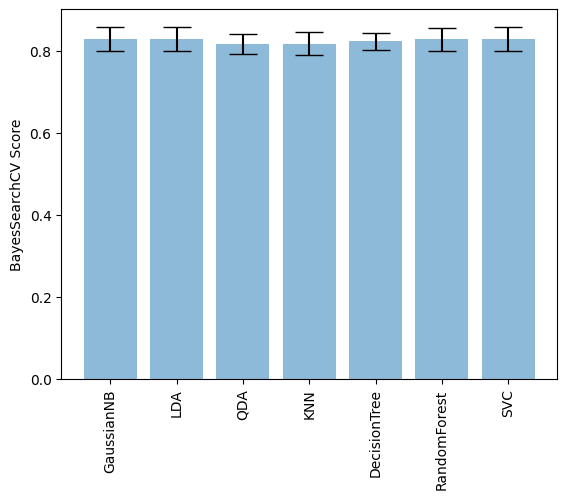

,GaussianNB,LDA,QDA,KNN,DecisionTree,RandomForest,SVC
Accuracy,0.829,0.829,0.816,0.817,0.823,0.827,0.829
StandardDeviation,0.029,0.029,0.025,0.027,0.021,0.028,0.029


In [95]:
bars_ = np.zeros((2,len(bestModelsCV))) # Bar Array for Best Model's Mean Score and STD 

modelLabels = ["GaussianNB", "LDA", "QDA", "KNN", "DecisionTree", "RandomForest", "SVC"]

for i in range(len(bestModelsCV)):
  ind = bestModelsCV[i]['mean_test_score'].argmax() # Best Classification Score Model
  bars_[0,i] = bestModelsCV[i]['mean_test_score'][ind] # Best Mean Score 
  bars_[1,i] = bestModelsCV[i]['std_test_score'][ind] # Best STD Score

# Bar Display
plt.bar(np.arange(len(bestModelsCV)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('BayesSearchCV Score')
plt.xticks(np.arange(len(bestModelsCV)), rotation='vertical')
plt.gca().set_xticklabels(modelLabels)
plt.show()

# Results DataFrame
results = pd.DataFrame(
    [np.round(bars_[0,:], 3), np.round(bars_[1,:], 3)],
    index=["Accuracy", "StandardDeviation"],
    columns=modelLabels
)

display(results)

## **Confusion Matrix and Classification Report**

Evaluando modelo GaussianNB (1/7)


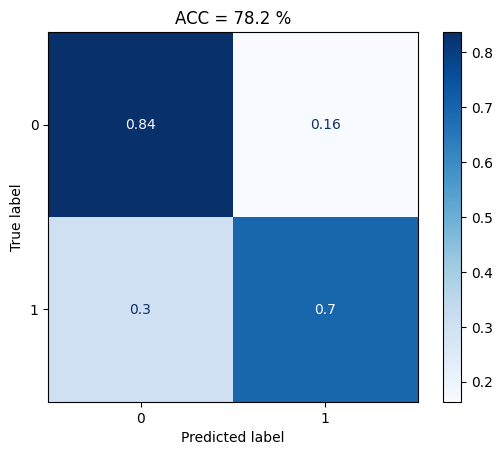

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       110
           1       0.73      0.70      0.71        69

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179

Evaluando modelo LDA (2/7)


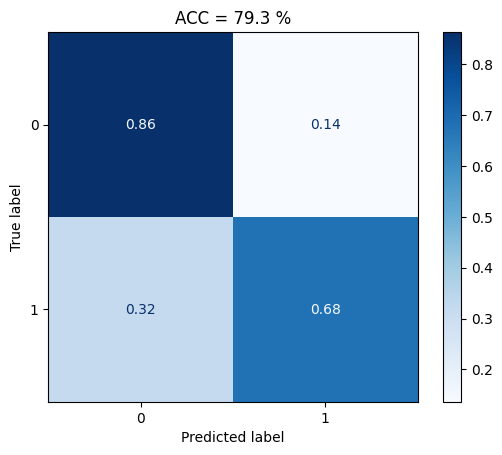

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       110
           1       0.76      0.68      0.72        69

    accuracy                           0.79       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.79      0.79      0.79       179

Evaluando modelo QDA (3/7)


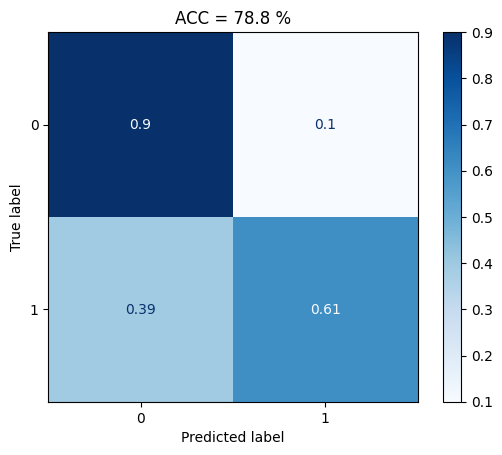

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       110
           1       0.79      0.61      0.69        69

    accuracy                           0.79       179
   macro avg       0.79      0.75      0.76       179
weighted avg       0.79      0.79      0.78       179

Evaluando modelo KNN (4/7)


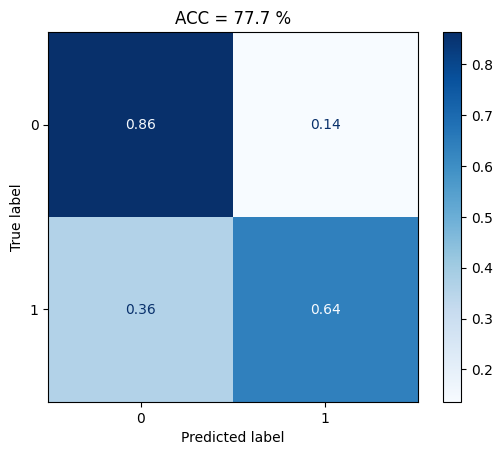

              precision    recall  f1-score   support

           0       0.79      0.86      0.83       110
           1       0.75      0.64      0.69        69

    accuracy                           0.78       179
   macro avg       0.77      0.75      0.76       179
weighted avg       0.77      0.78      0.77       179

Evaluando modelo DecisionTree (5/7)


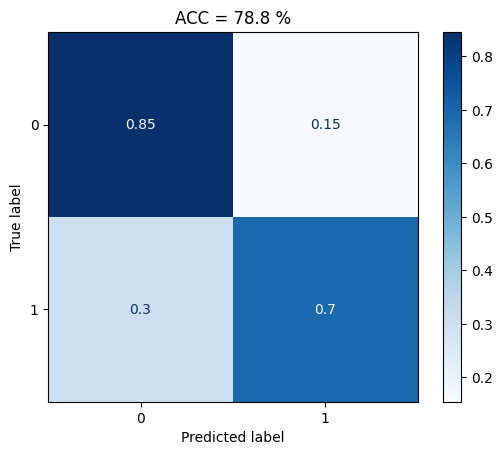

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       110
           1       0.74      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179

Evaluando modelo RandomForest (6/7)


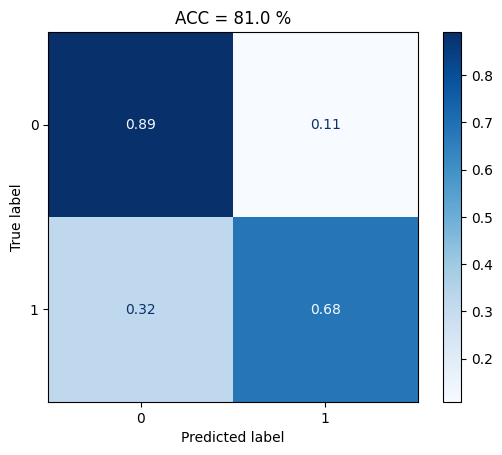

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       110
           1       0.80      0.68      0.73        69

    accuracy                           0.81       179
   macro avg       0.81      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

Evaluando modelo SVC (7/7)


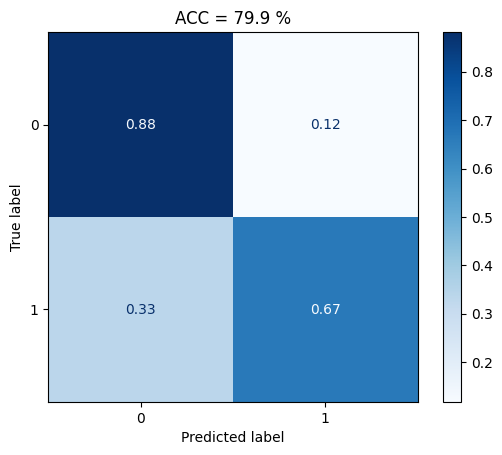

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



In [96]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

for i in range(len(bestModels)):
    
    print('Evaluando modelo %s (%d/%d)' % (modelLabels[i],i+1,len(bestModels)))

    y_test_e = bestModels[i].predict(X_test)
    acc = accuracy_score(y_test,y_test_e)

    title = 'ACC = %.1f %%' % (100*acc)
    disp = ConfusionMatrixDisplay.from_estimator(
        bestModels[i],
        X_test,
        y_test,
        cmap=plt.cm.Blues, 
        normalize='true'
    )
    disp.ax_.set_title(title)
    plt.show()

    cr = classification_report(y_test, y_test_e)
    print(cr)

## **PrecisionRecall, ROC (AUC), DET Curves**

Evaluando modelo GaussianNB (1/7)
Evaluando modelo LDA (2/7)
Evaluando modelo QDA (3/7)
Evaluando modelo KNN (4/7)
Evaluando modelo DecisionTree (5/7)
Evaluando modelo RandomForest (6/7)
Evaluando modelo SVC (7/7)


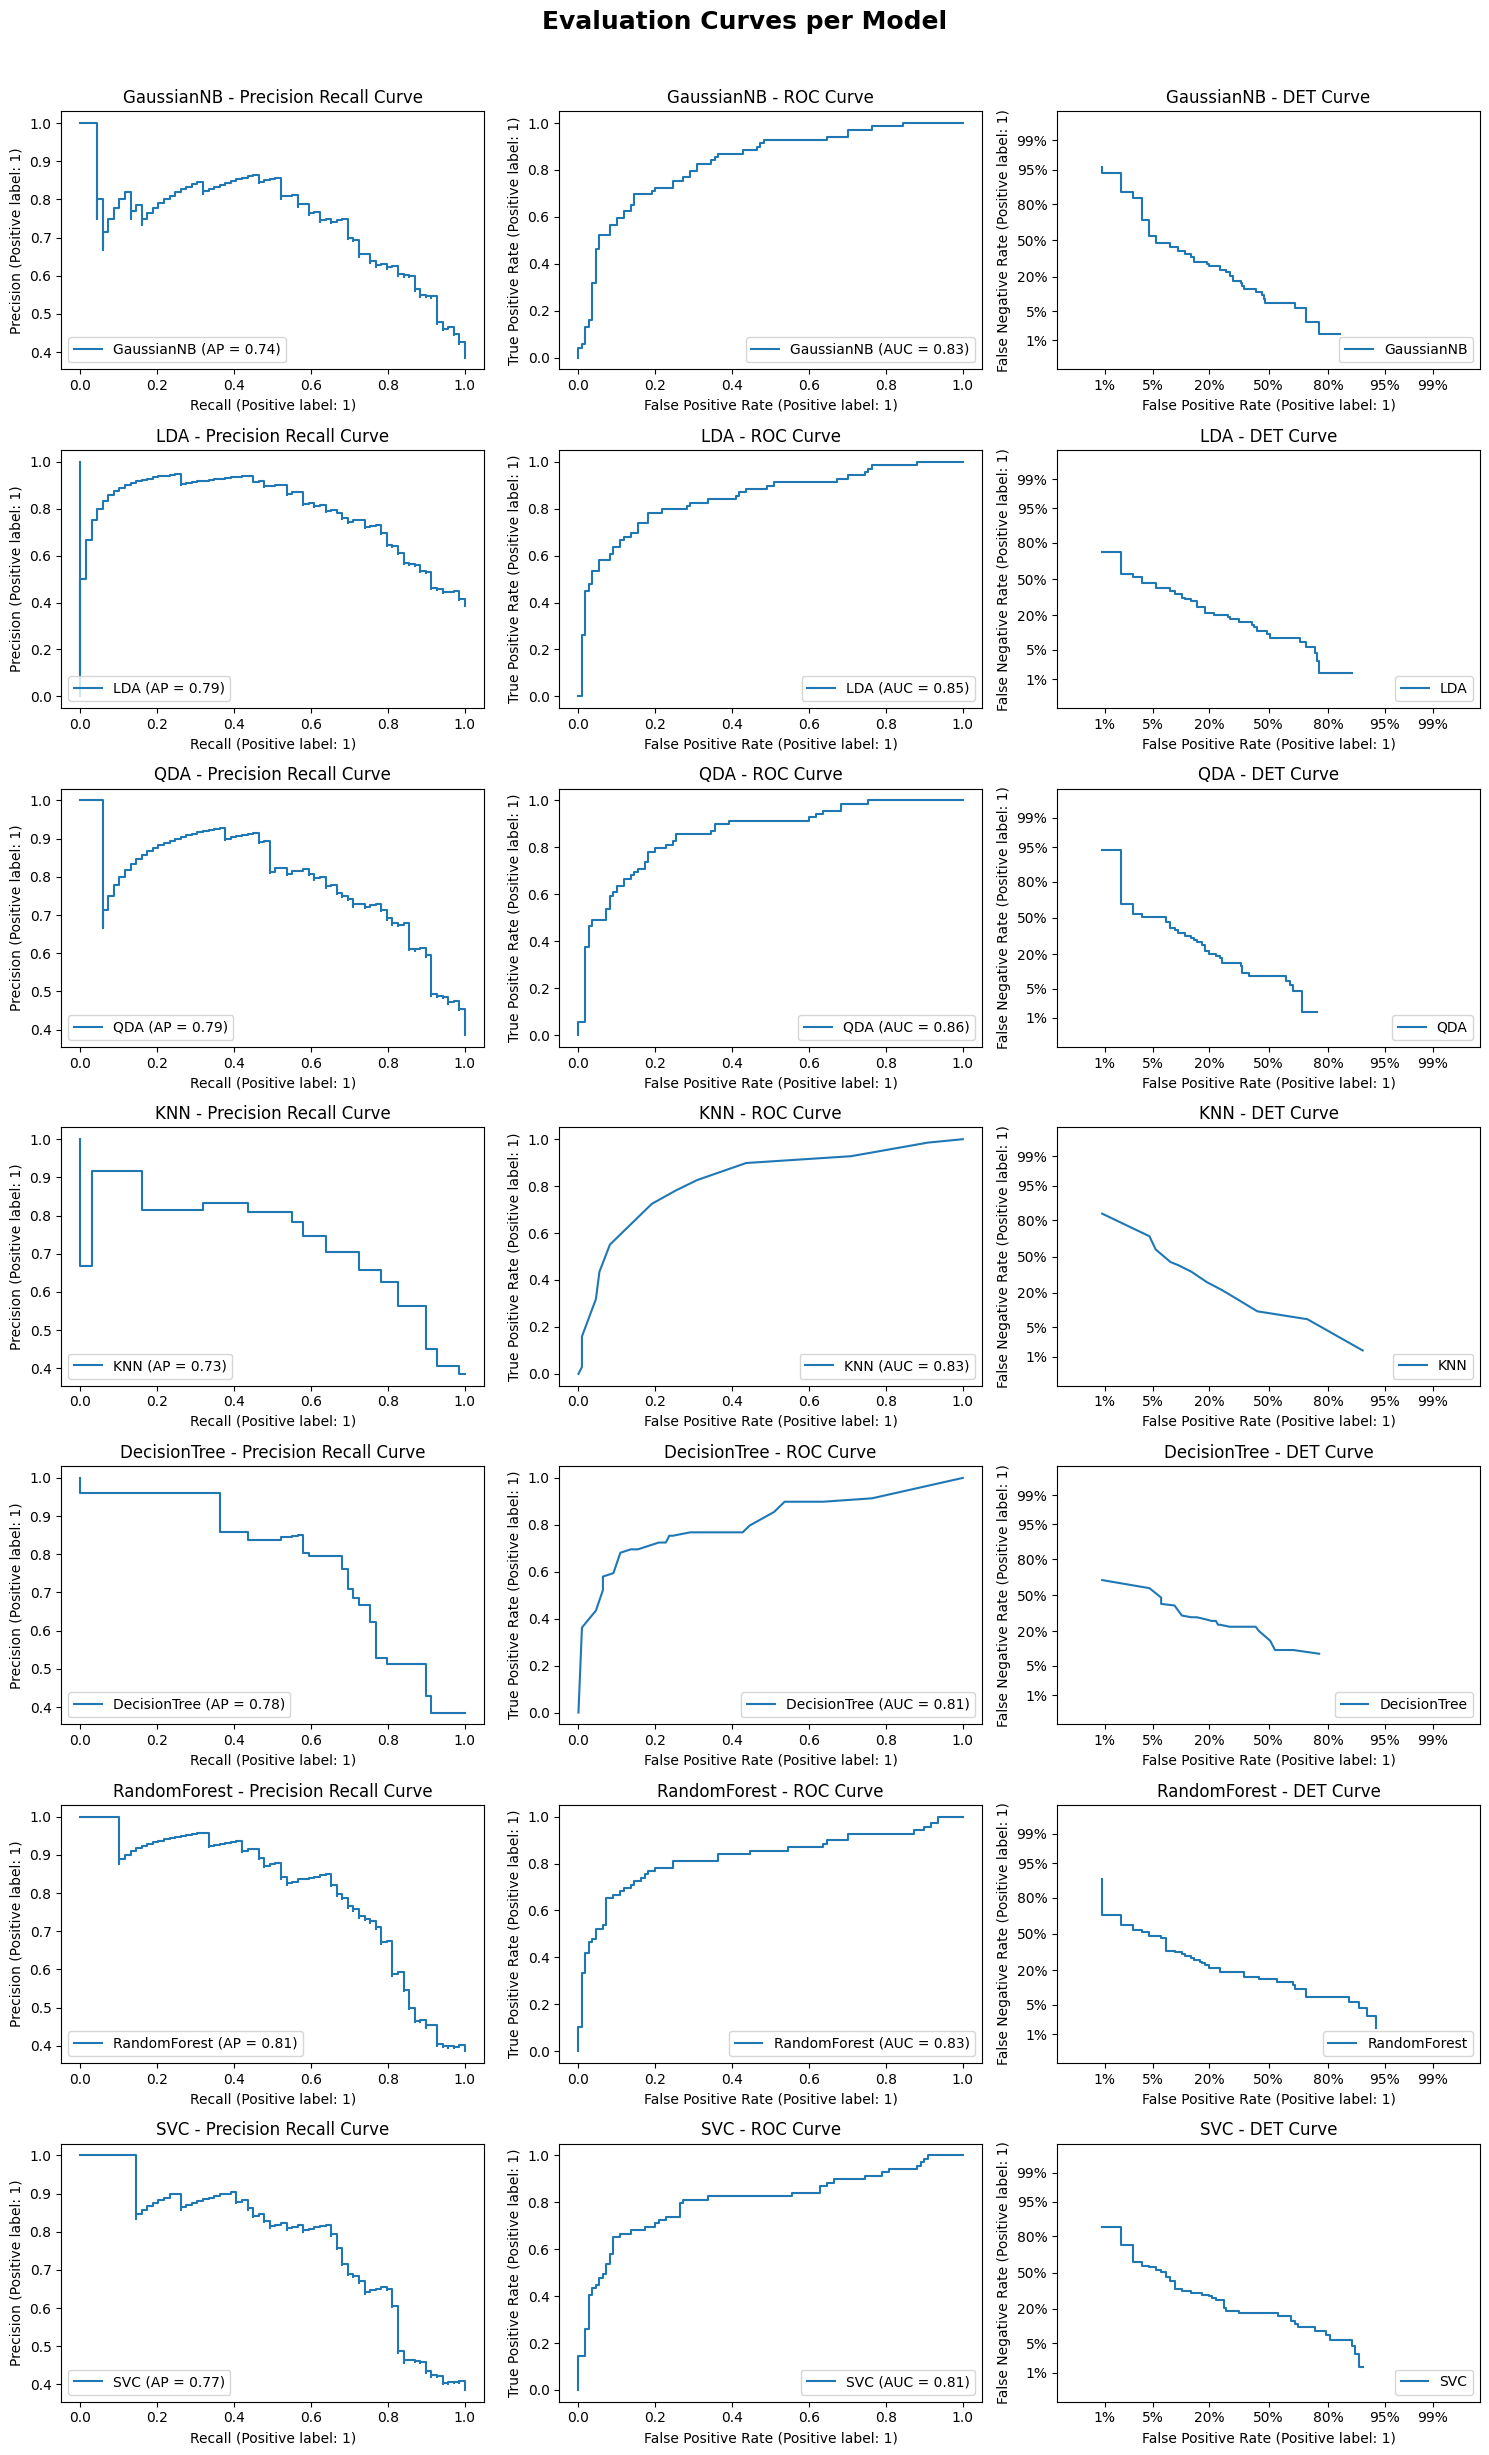

In [116]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, DetCurveDisplay

fig, axes = plt.subplots(len(modelLabels), 3, figsize=(15, 25))  # 7x3 grid
fig.suptitle("Evaluation Curves per Model", fontsize=18, fontweight="bold")

for i, label in enumerate(modelLabels):
    print('Evaluando modelo %s (%d/%d)' % (label, i+1, len(bestModels)))
    
    ax = axes[i]
    model = bestModels[i]
    
    # Precision-Recall Curve
    dispPR = PrecisionRecallDisplay.from_estimator(
        model, X_test, y_test, ax=axes[i, 0], name=label
    )
    axes[i, 0].set_title(f"{label} - Precision Recall Curve")

    # ROC Curve
    dispRC = RocCurveDisplay.from_estimator(
        model, X_test, y_test, ax=axes[i, 1], name=label
    )
    axes[i, 1].set_title(f"{label} - ROC Curve")

    # DET Curve
    dispDC = DetCurveDisplay.from_estimator(
        model, X_test, y_test, ax=axes[i, 2], name=label
    )
    axes[i, 2].set_title(f"{label} - DET Curve")

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()